<a href="https://colab.research.google.com/github/BrokenShell/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test? 
 
 Answer: P(A|B) = 1.236% after 1 tests
 - What is the probability that a person is drunk after two positive breathalyzer tests? 
 
 Answer: P(A|B) = 13.525% after 2 tests
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit? 
 
 Answer: 4




\begin{align}
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
\end{align}
<br><br>

\begin{aligned}
P(Drunk | Positive) &= \frac{P(Positive | Drunk)P(Drunk)}{P(Positive)} \\
&= \frac{1 \times 0.001}{0.08} \\
&= 0.0125
\end{aligned}
<br>

### The Code

I'm using a diffeent naming strategy to help keep things straight in my head. I also parameterized additional variables to help create a more complete and general solution.

In [0]:
def bayes_theorem(p_a, p_b_given_a, p_b_given_not_a, confidence):
    """
    Calculates the probability of A given B, P(A|B)
    Also calculates the number of tests that need to be run
    to get to the desired confidence. Maximum number of tests: 100

    @param p_a: Float, P(A), prior belief
    @param p_b_given_a: Float, P(B|A), true positive
    @param p_b_given_not_a: Float, P(B|!A), false positive
    @param confidence: Float, target rating
    @return: String, P(A|B) and the number of tests needed
    """
    p_a_given_b = 0
    exp = 0
    while p_a_given_b <= confidence:
        exp += 1
        assert exp < 100, "Test Failed, confidence level untenable."
        not_a = 1.0 - p_a
        p_b = p_b_given_a * p_a + p_b_given_not_a**exp * not_a
        p_a_given_b = (p_b_given_a * p_a) / p_b
    return f"P(A|B) is {p_a_given_b * 100:.3f}% after {exp} tests"

In [0]:
prior_belief = 1/1000  # P(A)
true_positive = 1.0    # P(B|A)
false_positive = 0.08  # P(B|!A
confidence_rate = 0.95 # Target P(A|B)

print(bayes_theorem(
    prior_belief, 
    true_positive, 
    false_positive, 
    confidence_rate,
))

P(A|B) is 96.069% after 4 tests


### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical lines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)


In [0]:
from scipy import stats
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [0]:
monsters = pd.read_csv('https://sharpdesigndigital.com/monsters.csv')

### Bayes

In [0]:
print("AC by Tier: Bayes")
for i in range(7):
    mean, _, _ = stats.bayes_mvs(monsters[monsters['Tier'] == i]['AC'])
    mean, (lo, hi) = mean
    print(f"Tier: {i}: {mean:.2f}, {lo:.2f}, {hi:.2f}")

AC by Tier: Bayes
Tier: 0: 9.48, 9.43, 9.54
Tier: 1: 12.76, 12.70, 12.82
Tier: 2: 15.77, 15.72, 15.82
Tier: 3: 17.62, 17.55, 17.68
Tier: 4: 18.74, 18.65, 18.84
Tier: 5: 19.88, 19.73, 20.02
Tier: 6: 21.10, 20.79, 21.42


### Frequentist

In [0]:
def confidence_interval(data, confidence = 0.95):
    """
    Calculates a confidence interval around a sample mean for given data.
    Using t-distribution and two-tailed test, default 95% confidence. 

    @param data: Iterable. Sample observations
    @param confidence: Float, default = 0.95, confidence level for the interval
    @return: Tuple (mean, lower bound, upper bound)
    """
    data = np.array(data)
    mean = np.mean(data)
    n = len(data)
    stderr = np.std(data, ddof=1) / np.sqrt(n)
    moe = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return mean, mean - moe, mean + moe

In [0]:
print("AC by Tier: Frequentist")
for i in range(7):
    mean, lo, hi = confidence_interval(monsters[monsters['Tier'] == i]['AC'])
    print(f"Tier: {i}: {mean:.2f}, {lo:.2f}, {hi:.2f}")

Tier: 0: 9.48, 9.42, 9.55
Tier: 1: 12.76, 12.69, 12.83
Tier: 2: 15.77, 15.71, 15.83
Tier: 3: 17.62, 17.54, 17.69
Tier: 4: 18.74, 18.63, 18.85
Tier: 5: 19.88, 19.70, 20.05
Tier: 6: 21.10, 20.72, 21.48


The two approaches produce nearly the same results for this data.

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

**Bayesian statistics has a broader interpretation of what probabilities are fundamentally. Frequentists can only attribute probability to events that are random and repeatable. Where Bayesian's will assign probabilities to any unknown variable. For this reason Bayesian statisticians can take prior knowledge into account for future predictions in a way that Frequentists can not.**

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!

1. Check
2. See AC stats by Tier above
3. WOW PyMC3 is slow! See below...

In [0]:
import pymc3 as pm
import theano.tensor as tt

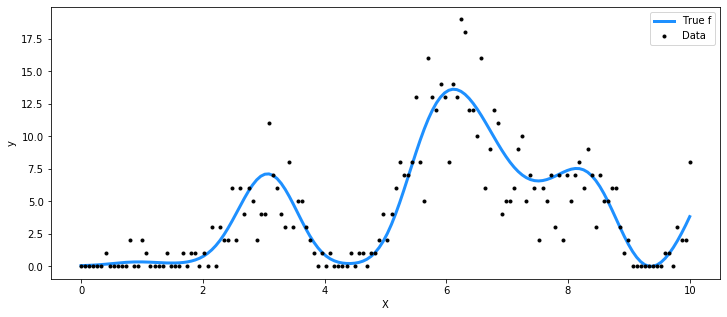

In [0]:
np.random.seed(7)

n = 150 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = pm.MvStudentT.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval(), nu=3).random(size=1)
y = np.random.poisson(f_true**2)

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true**2, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

## WARNING: The next cell takes forever to run!!! OMG I'm not kidding.

In [0]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=2)
    η = pm.HalfCauchy("η", beta=3)
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)

    # informative prior on degrees of freedom < 5
    ν = pm.Gamma("ν", alpha=2, beta=1)
    tp = pm.gp.TP(cov_func=cov, nu=ν)
    f = tp.prior("f", X=X)

    # adding a small constant seems to help with numerical stability here
    y_ = pm.Poisson("y", mu=tt.square(f) + 1e-6, observed=y)

    tr = pm.sample(1000)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
INFO (theano.gof.compilelock): Refre

In [0]:
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = tp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(tr, vars=[f_pred], samples=1000)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
100%|██████████| 1000/1000 [01:46<00:00,  9.41it/s]


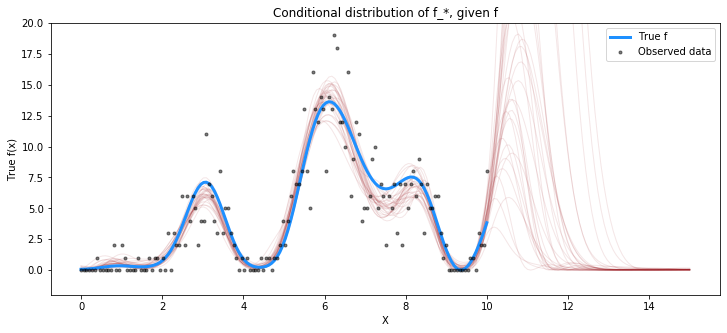

In [0]:
from pymc3.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, np.square(pred_samples["f_pred"]), X_new);
plt.plot(X, np.square(f_true), "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)"); plt.ylim([-2, 20])
plt.title("Conditional distribution of f_*, given f"); plt.legend();